<a href="https://colab.research.google.com/github/schokoro/cnn_crf_nertagger/blob/dev/NER_tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN и CRF для извлечения именованных сущностей



In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    

Tesla T4


In [0]:
import sys
sys.path.append('/content/cnn_crf_nertagger')

In [0]:
!rm -rf cnn_crf_nertagger/

In [4]:
!git clone -b dev https://github.com/schokoro/cnn_crf_nertagger.git > /dev/null
!pip install allennlp wget youtokentome ipymarkup seqeval> /dev/null


Cloning into 'cnn_crf_nertagger'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 179 (delta 85), reused 140 (delta 57), pack-reused 0
Receiving objects: 100% (179/179), 138.19 KiB | 326.00 KiB/s, done.
Resolving deltas: 100% (85/85), done.
ERROR: en-core-web-sm 2.2.5 has requirement spacy>=2.2.2, but you'll have spacy 2.1.9 which is incompatible.


In [0]:
%load_ext autoreload
%autoreload 2

import spacy
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from allennlp.data.dataset_readers.conll2003 import Conll2003DatasetReader
from allennlp.common.util import ensure_list
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from pdb import set_trace
from gc import collect
from tqdm.notebook import tqdm
import wget
import cnn_crf_nertagger
from cnn_crf_nertagger.modules.modules import NERTaggerModel, NERTagger
from cnn_crf_nertagger.utils.pipeline import train_eval_loop, predict_with_model
from cnn_crf_nertagger.utils.prepare import tag_corpus_to_tensor, tokenize_corpus, make_yttm_tokenizer, highlight_text, tensor_to_tags
from os import path, listdir
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from seqeval.metrics import classification_report
sns.set()
%matplotlib inline

rcParams['figure.figsize'] = 12, 12
torch.backends.cudnn.deterministic=False 

## Подготовка данных




### Загружаем корпуса

In [6]:
!rm -fv /content/cnn_crf_nertagger/data/*


removed '/content/cnn_crf_nertagger/data/readme.txt'


In [0]:
path_data = '/content/cnn_crf_nertagger/data/'
path_train = '/content/cnn_crf_nertagger/data/eng.train'
path_valid = '/content/cnn_crf_nertagger/data/eng.testa'
path_test = '/content/cnn_crf_nertagger/data/eng.testb'

dataset_urls = {
    'eng.testa': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa',
    'eng.testb': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb',
    'eng.train': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train'}
for file_name in dataset_urls:
    wget.download(dataset_urls[file_name], path.join(path_data, file_name))

In [8]:
%%time
conll_reader = Conll2003DatasetReader()
train_conll = ensure_list(conll_reader.read(path_train))
valid_conll = ensure_list(conll_reader.read(path_valid))
test_conll = ensure_list(conll_reader.read(path_test))

14041it [00:01, 12288.51it/s]
3250it [00:00, 8885.83it/s]
3453it [00:00, 23020.20it/s]

CPU times: user 1.59 s, sys: 77.1 ms, total: 1.66 s
Wall time: 1.67 s


In [9]:
all_conll = train_conll + valid_conll + test_conll
len(all_conll), len(train_conll), len(valid_conll), len(test_conll)

(20744, 14041, 3250, 3453)

### Готовим словари соответсвия тег-id и bpe - токенизатор



In [10]:
tags = set()
tokens = set()

max_sent_len = 0
for instance in all_conll[: ]:
    if len(instance['tokens']) >  max_sent_len:
        max_sent_len = len(instance['tokens'])
    tags.update(instance['tags'])
    tokens.update(instance['tokens'])
    
print(f'Максимальная длина предложения: {max_sent_len} токенов')

Максимальная длина предложения: 124 токенов


In [11]:
%time bpe_tokenizer = make_yttm_tokenizer(train_conll, 500)

CPU times: user 175 ms, sys: 24.9 ms, total: 199 ms
Wall time: 149 ms


In [12]:
%%time
max_token_len = 0
for p in tqdm(range(101)):
    len_tokens = [len(bpe_tokenizer.encode(token.text, dropout_prob=p/100))  for token in tokens]
    if max(len_tokens) > max_token_len:
        p_dropout = .01 * p
        max_token_len = max(len_tokens)

print(f'Максимальная длина токена: {max_token_len} субтокенов при вероятности дропаута {p_dropout}')


Максимальная длина токена: 62 субтокенов при вероятности дропаута 0.11
CPU times: user 10.5 s, sys: 75.1 ms, total: 10.6 s
Wall time: 10.6 s


In [0]:
tag2id = {tag: num for num, tag in enumerate(['<NOTAG>'] + list(tags))}
# char2id = {char: num+1 for num, char in enumerate(chars)}
# id2char = {item[1]: item[0] for item in char2id.items()}

В датасете присутствует очень мало тегов вида B-XXX. Попробуем чуть размножить предложения с этими тегами. Использование дропаута в bpe внесёт немного разнообразия в эти предложения.

In [14]:
%%time
BPE_DROPOUT = .2
train_inputs, train_targets = tag_corpus_to_tensor(train_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len, augm=20, dropout=BPE_DROPOUT)
valid_inputs, valid_targets = tag_corpus_to_tensor(valid_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len, dropout=0)
test_inputs, test_targets = tag_corpus_to_tensor(test_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len, dropout=0)

100%|██████████| 3453/3453 [00:01<00:00, 2519.68it/s]

CPU times: user 9.59 s, sys: 810 ms, total: 10.4 s
Wall time: 10.5 s


In [0]:
train_dataset = TensorDataset(train_inputs, train_targets)
valid_dataset = TensorDataset(valid_inputs, valid_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

## Создаём и обучаем сеть

In [0]:
models_path = '/content/cnn_crf_nertagger/models/best_model.pth'

In [17]:
try:
    del model    
    collect()
except:
    print('no model')
finally:
    torch.cuda.empty_cache()


no model


Сеть состоит из двух однотипных свёрточных блоков и CRF. На первом уровне мы осуществляем свёртку над субтокенами и делаем глобал-пуллинг. Затем получившиеся эмбедденги токенов передаём на следующий свёрточный блок. Он значительно глубже, чтобы увеличить рецептивное поле. Выход второго блока передаём в CRF, который возвращает нам `log-likelihood`.

In [18]:
torch.cuda.empty_cache()
model = NERTaggerModel(len(bpe_tokenizer.vocab()), len(tag2id), tag2id, embedding_size=64,
                                              single_backbone_kwargs=dict(layers_n=2, kernel_size=3, dropout=0.3, dilation=None),
                                              context_backbone_kwargs=dict(layers_n=5, kernel_size=3, dropout=0.3, dilation=[1, 1, 2 , 2, 2]))
print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

Количество параметров 119269


In [0]:
# try:
#     model.load_state_dict(torch.load(models_path))
# except:
#     print('no model')

In [33]:
(best_val_loss,
 best_model,
 losses) = train_eval_loop(model,
                               train_dataset,
                               valid_dataset,
                               lr=5e-6,
                               epoch_n=200,
                               batch_size=128,
                               device=device,
                               early_stopping_patience=10,
                               l2_reg_alpha = 1e-6,
                               max_batches_per_epoch_train=100,
                               max_batches_per_epoch_val=100,
                               lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                                                                     optim, patience=4,
                                                                                     factor=0.1,
                                                                                     threshold=1e-3,
                                                                                     verbose=True),
                               verbose_batch=False)
 
torch.save(best_model.state_dict(), models_path)

Эпоха 0
Эпоха: 101 итераций, 23.83 сек
Среднее значение функции потерь на обучении 0.37689943080491356
Среднее значение функции потерь на валидации 0.9942977858277467
Новая лучшая модель!

Эпоха 1
Эпоха: 101 итераций, 23.78 сек
Среднее значение функции потерь на обучении 0.38268873862700886
Среднее значение функции потерь на валидации 0.9945038972565761

Эпоха 2
Эпоха: 101 итераций, 23.79 сек
Среднее значение функции потерь на обучении 0.3684569194470302
Среднее значение функции потерь на валидации 0.9948714937155063

Эпоха 3
Эпоха: 101 итераций, 23.93 сек
Среднее значение функции потерь на обучении 0.37039414195731135
Среднее значение функции потерь на валидации 0.9949355303094938

Эпоха 4
Эпоха: 101 итераций, 23.86 сек
Среднее значение функции потерь на обучении 0.3805220395621687
Среднее значение функции потерь на валидации 0.9950142488456689

Эпоха 5
Эпоха: 101 итераций, 23.91 сек
Среднее значение функции потерь на обучении 0.37660082186212634
Среднее значение функции потерь на вал

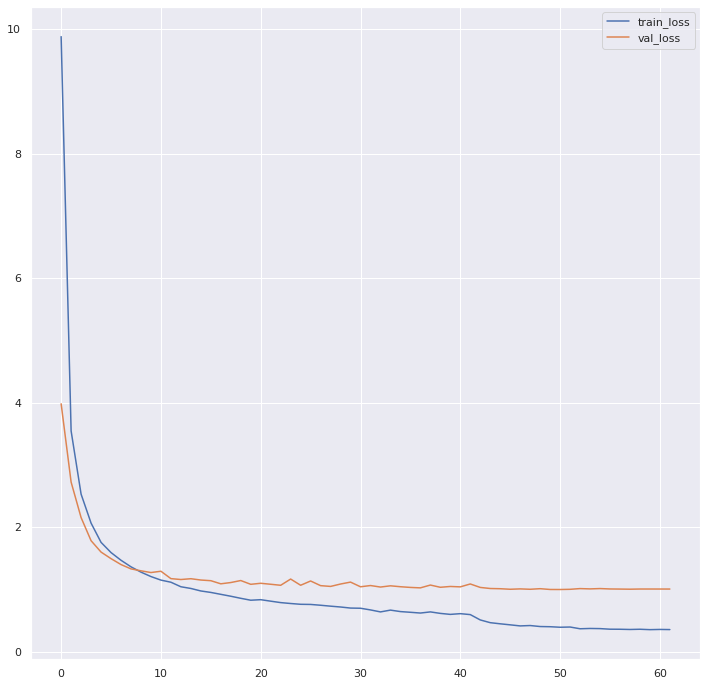

In [21]:
pd.DataFrame(losses).plot();

In [34]:
model.load_state_dict(torch.load(models_path))

<All keys matched successfully>

## Проверки

In [0]:
id2tag = {item[1]: item[0] for item in tag2id.items()}
UNIQUE_TAGS = [id2tag[i] for i in range(len(tag2id))]


### Проверка - train

In [35]:
train_pred = predict_with_model(model, train_dataset)
train_golden_tags = tensor_to_tags(train_targets, id2tag)
train_pred_tags = tensor_to_tags(train_pred, id2tag)
print(classification_report(train_golden_tags, train_pred_tags))
print(classification_report(train_golden_tags, train_pred_tags, suffix=True))


472it [00:17, 27.33it/s]                               


           precision    recall  f1-score   support

     MISC       0.85      0.86      0.85      5098
      ORG       0.83      0.88      0.86      7201
      PER       0.97      0.97      0.97      6860
      LOC       0.93      0.93      0.93      8100

micro avg       0.90      0.91      0.91     27259
macro avg       0.90      0.91      0.91     27259

           precision    recall  f1-score   support

        I       0.91      0.96      0.93     26078
        B       0.72      0.52      0.60      1134

micro avg       0.90      0.94      0.92     27212
macro avg       0.90      0.94      0.92     27212



### Проверка - valid

In [36]:
valid_pred = predict_with_model(model, valid_dataset)

 
valid_golden_tags = tensor_to_tags(valid_targets, id2tag)
valid_pred_tags = tensor_to_tags(valid_pred, id2tag)
print(classification_report(valid_golden_tags, valid_pred_tags))
print(classification_report(valid_golden_tags, valid_pred_tags, suffix=True))


100%|██████████| 102/101.5625 [00:03<00:00, 25.63it/s]


           precision    recall  f1-score   support

     MISC       0.78      0.80      0.79       922
      PER       0.90      0.87      0.89      1842
      ORG       0.72      0.79      0.75      1341
      LOC       0.86      0.90      0.88      1837

micro avg       0.83      0.85      0.84      5942
macro avg       0.83      0.85      0.84      5942

           precision    recall  f1-score   support

        I       0.90      0.93      0.91      5899
        B       0.09      0.25      0.13         4

micro avg       0.90      0.93      0.91      5903
macro avg       0.90      0.93      0.91      5903



### Проверка - test

In [37]:
test_pred = predict_with_model(model, test_dataset)
 
test_golden_tags = tensor_to_tags(test_targets, id2tag)
test_pred_tags = tensor_to_tags(test_pred, id2tag)
print(classification_report(test_golden_tags, test_pred_tags))
print(classification_report(test_golden_tags, test_pred_tags, suffix=True))

100%|██████████| 108/107.90625 [00:03<00:00, 27.57it/s]


           precision    recall  f1-score   support

      PER       0.84      0.82      0.83      1617
     MISC       0.64      0.70      0.67       702
      ORG       0.68      0.74      0.71      1661
      LOC       0.81      0.87      0.84      1668

micro avg       0.75      0.80      0.77      5648
macro avg       0.76      0.80      0.78      5648

           precision    recall  f1-score   support

        I       0.87      0.92      0.89      5599
        B       0.00      0.00      0.00        18

micro avg       0.87      0.91      0.89      5617
macro avg       0.86      0.91      0.89      5617



## Применение теггера

In [0]:
!python -m spacy download en_core_web_sm > /dev/null
nlp = spacy.load('en_core_web_sm')

In [0]:

ner_tagger = NERTagger(model, bpe_tokenizer, UNIQUE_TAGS, max_sent_len, max_token_len, 0)

Несколько предложений из новостей с сайта [BBC](https://www.bbc.com/news)

In [0]:
test_sentences = [
    'Mr Trump said Mr Linick no longer had his full confidence and that he would be removed in 30 days.',
    'Mr Linick had begun investigating Secretary of State Mike Pompeo for suspected abuse of office, reports say.',
    'Democrats say Mr Trump is retaliating against public servants who want to hold his administration to account.',
    'Donald Trump, who is campaigning for re-election in November, has stepped up his attacks on China in recent weeks, blaming it for the spread of Covid-19.',
    'The team led by Fernando Novas from the Natural Sciences Museum in Buenos Aires discovered many fossils during its month-long field work in Estancia La Anita, in southern Santa Cruz province.',
    "The rehearsal at Kennedy Space Center saw a Falcon-9 vehicle's ascent into the sky deliberately terminated just 80 seconds after lift-off."
]
test_sentences_tokenized = tokenize_corpus(test_sentences)
# test_sentences_tokenized = [[token.text for token in nlp.tokenizer(sent) ] for sent in test_sentences]

In [39]:
for sent_tokens, sent_tags in zip(test_sentences_tokenized, ner_tagger(test_sentences)):
    highlight_text(sent_tokens, sent_tags)

1it [00:00, 71.75it/s]                    
